In [49]:
import pandas as pd
import scipy.stats as scipy
import numpy as np

In [2]:
jeopardy = pd.read_csv('jeopardy.csv')

In [3]:
print(jeopardy.head())

   Show Number    Air Date      Round                         Category  Value  \
0         4680  2004-12-31  Jeopardy!                          HISTORY   $200   
1         4680  2004-12-31  Jeopardy!  ESPN's TOP 10 ALL-TIME ATHLETES   $200   
2         4680  2004-12-31  Jeopardy!      EVERYBODY TALKS ABOUT IT...   $200   
3         4680  2004-12-31  Jeopardy!                 THE COMPANY LINE   $200   
4         4680  2004-12-31  Jeopardy!              EPITAPHS & TRIBUTES   $200   

                                            Question      Answer  
0  For the last 8 years of his life, Galileo was ...  Copernicus  
1  No. 2: 1912 Olympian; football star at Carlisl...  Jim Thorpe  
2  The city of Yuma in this state has a record av...     Arizona  
3  In 1963, live on "The Art Linkletter Show", th...  McDonald's  
4  Signer of the Dec. of Indep., framer of the Co...  John Adams  


In [4]:
print(jeopardy.columns)

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')


In [5]:
jeopardy.columns=  [x.strip() for x in jeopardy.columns]

In [6]:
print(jeopardy.columns)

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')


In [7]:
jeopardy.dtypes

Show Number     int64
Air Date       object
Round          object
Category       object
Value          object
Question       object
Answer         object
dtype: object

In [8]:
import re

def normalize_text(text):
    text = text.lower()
    text = re.sub("[^A-Za-z0-9\s]", "", text)
    return text

def normalize_values(text):
    text = re.sub("[^A-Za-z0-9\s]", "", text)
    try:
        text = int(text)
    except Exception:
        text = 0
    return text

In [9]:
jeopardy['clean_question'] = jeopardy['Question'].apply(normalize_text)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(normalize_text)
jeopardy['clean_value'] = jeopardy['Value'].apply(normalize_values)


In [10]:
jeopardy['Air Date'] =pd.to_datetime(jeopardy['Air Date'])

In [11]:
def clean_answer(row):
    split_answer = row['clean_answer'].split(' ')
    split_question = row['clean_question'].split(' ')
    match_count = 0 
    try:
        split_answer.remove('the')
    except:
        pass
    if len(split_answer) == 0:
        return 0
    else:
        for each in split_answer:
            if each in split_question:
                match_count +=1
    return (match_count / int(len(split_answer)))

In [12]:
jeopardy['answer_in_question'] = jeopardy.apply(axis=1, func = clean_answer)

In [13]:
jeopardy['answer_in_question'].head(20)

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.333333
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.500000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
Name: answer_in_question, dtype: float64

In [54]:
jeopardy.sort_values(by = "Air Date", inplace=True)

In [55]:
question_overlap = []
terms_used  = set()
for i,row in jeopardy.iterrows():
    split_question = row['clean_question'].split(' ')
    split_question = [q for q in split_question if len(q) > 5]
    match_count = 0 
    for word in split_question:
        if word in terms_used:
            match_count += 1
        terms_used.add(word)
    if len(split_question) > 0:
        match_count /= len(split_question)
    question_overlap.append(match_count)


In [56]:
jeopardy['question_overlap'] = question_overlap

In [57]:
print(jeopardy['question_overlap'].mean())

0.6894972318476833


If the stat is equal to one, it means every word in the question was seen at least once in the past. It doesn't necessarily mean the exact question was repeated, but it could be an indication that some elements of the questions are. Since over 6000 of the questions have a ratio of found words to length of question greater than 80%, its possible questions are being repeated, or at least their subjects might be. 

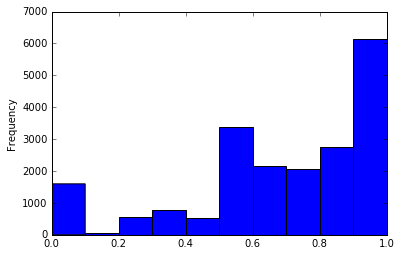

In [58]:
%matplotlib inline
jeopardy['question_overlap'].plot.hist()

In [59]:
def val_lab(row):
    if row['clean_value'] > 800:
        value = 1
    else:
        value = 0
    return value
        

In [60]:
jeopardy['high_value'] = jeopardy.apply(axis=1,func = val_lab)

In [61]:
def word_val(word):
    low_count = 0
    high_count = 0
    for i, row in jeopardy.iterrows():
        split_question = row['clean_question'].split(' ')
        if word in split_question:
            if row['high_value'] == 1:
                high_count += 1
            else:
                low_count += 1
    return high_count, low_count




observed_expected = []
comparison_terms = list(terms_used)[:5]

for each in comparison_terms:
    observed_expected.append(word_val(each))

In [62]:
observed_expected

[(1, 2), (1, 1), (1, 0), (4, 1), (0, 2)]

In [63]:
high_value_count = len(jeopardy[jeopardy['high_value'] == 1])

In [64]:
low_value_count = len(jeopardy[jeopardy['high_value'] == 0])

In [65]:
chi_squared = []
for each in observed_expected:
    total = sum(each)
    total_prop = total/ len(jeopardy)
    exp_high = total_prop * high_value_count
    exp_low = total_prop * low_value_count
    exp = np.array([exp_high, exp_low])
    obs = np.array([each[0],each[1]])
    chi_squared.append(scipy.chisquare(exp,obs))

    

/dataquest/system/env/python3/lib/python3.4/site-packages/scipy/stats/stats.py:4350: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


In [66]:
chi_squared

[Power_divergenceResult(statistic=0.029339967673417424, pvalue=0.8639964234445506),
 Power_divergenceResult(statistic=0.3639261967098555, pvalue=0.5463337707630747),
 Power_divergenceResult(statistic=inf, pvalue=0.0),
 Power_divergenceResult(statistic=8.233192911208139, pvalue=0.004113110511920707),
 Power_divergenceResult(statistic=inf, pvalue=0.0)]